In [2]:
%%html
<style>
#notebook-container {width: 100%;}
.code_cell {flex-direction: row !important;}
.code_cell .output_wrapper {width: 50%;left: 0px;}
.code_cell .input {width: 50%;}
</style>

In [3]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import scale
from scipy.stats import norm, pearsonr
from scipy.linalg import pinv
import numpy as np
import matplotlib.pyplot as plt
from models import JRR
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold



%matplotlib inline

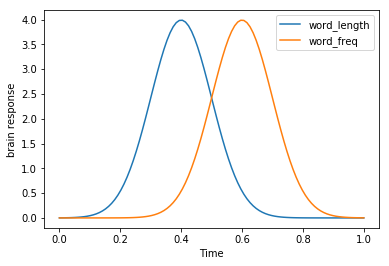

In [4]:
# Many neuroimaging study consist in identifying which factor cause brain activity.
# For example, some primary visual regions may respond proportionally to the size
# of a word (i.e. a low-level feature), whereas secondary areas may respond
# proportionnally to their frequency (i.e. a semantic, and thus high-level feature)
n_times = 100
time = np.linspace(0, 1, n_times)
word_length = norm.pdf(time, .4, .1)
word_freq = norm.pdf(time, .6, .1)
plt.plot(time, word_length, label='word_length')
plt.plot(time, word_freq, label='word_freq')
plt.xlabel('Time')
plt.ylabel('brain response')
plt.legend()

In [5]:
# Simulate 1000 brain responses to distinct words
Z = np.c_[word_length, word_freq].T  # typical dynamics of effects
n = 1000  # number of words
Cx = np.array([[1, -.8], [-.8, 1.]])  # feature covariance
X = np.random.multivariate_normal(np.zeros(2), Cx, n)  # word features
Y = X @ Z  # brain response
Y += np.random.randn(*Y.shape)  # add noise

#X = scale(X)
#Y = scale(Y)

Text(0,0.5,'betas')

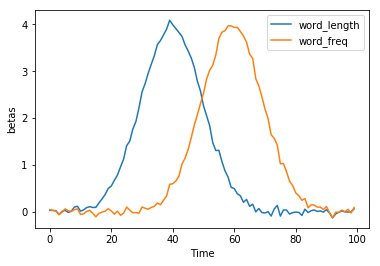

In [6]:
# Encoding analyses consist in predicting brain activity Y from the features X
# This approach can efficiently disentangle the causal contribution of each feature
ols = LinearRegression(fit_intercept=True)
encod = list()
for t in range(n_times):
    encod.append(ols.fit(X, Y[:, t]).coef_)
plt.plot(encod)
plt.legend(['word_length', 'word_freq'])
plt.xlabel('Time')
plt.ylabel('betas')

Text(0,0.5,'decoding score')

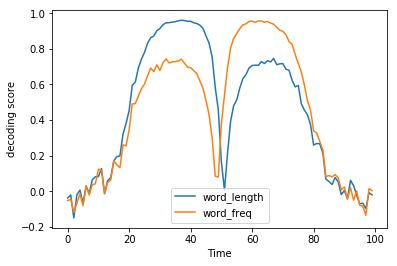

In [7]:
# Conversely, decoding analyses consist in predicting the features X from
# brain activity Y.
# This approach cannot efficiently disentangle the causal contribution of each feature

train, test = range(n//2), range(n//2, n)
ols = LinearRegression(fit_intercept=True)
decod = list()
for t in range(n_times):
    ols.fit(Y[train, t][:, None], X[train])
    X_hat = ols.predict(Y[test, t][:, None])
    R = list()
    for x, x_hat in zip(X[test].T, X_hat.T):
        r = pearsonr(x, x_hat)[0]
        R.append(r)
    decod.append(R)
plt.plot(decod)

plt.legend(['word_length', 'word_freq'])
plt.xlabel('Time')
plt.ylabel('decoding score')

In [8]:
# So why using decoding? Because we make multiple simultaneous measurements
# of noisy sources
F = np.array([[1., .5], [-.5, 1.]])  # forward: from source to sensor
Y = np.zeros((n, 2, n_times))
for t, (length, freq) in enumerate(zip(word_length, word_freq)):
    Z = np.c_[length, freq].T
    source = X @ Z
    # add source noise
    noise = np.random.randn(n) * 1e2
    source = np.c_[source, noise]
    # Y is now our multivariate measurement (i.e. sensors)
    Y[:, :, t] = source @ F
Y += np.random.randn(*Y.shape)  # add sensor noise

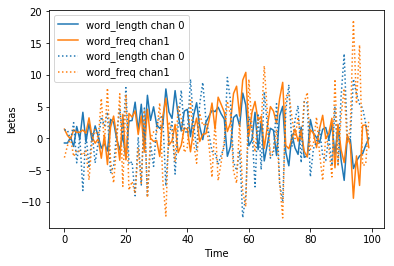

In [9]:
# In such condition, encoding can be dramatically bad
ols = LinearRegression(fit_intercept=True)
nx = 2
ny = 2
multi_encod = np.zeros((nx, ny, n_times))
for c in range(ny):
    for t in range(n_times):
        multi_encod[:, c, t] = ols.fit(X, Y[:, c, t]).coef_
plt.legend(['word_length', 'word_freq'])

for c in range(2):
    for beta, label in enumerate(['word_length chan %i', 'word_freq chan%i']):
        plt.plot(multi_encod[beta, c].T, 
                 linestyle='-:'[c],
                 color='C%i' % beta, label=label % beta)
plt.xlabel('Time')
plt.ylabel('betas')
plt.legend()

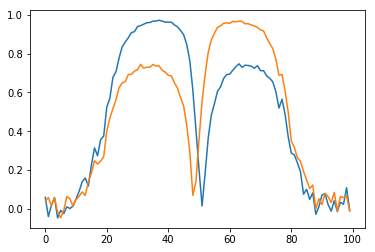

In [10]:
# whereas decoding clearly show that a lot of signal remain detectable
train, test = range(n//2), range(n//2, n)
ols = LinearRegression(fit_intercept=True)
multi_decod = list()
for t in range(n_times):
    ols.fit(Y[train, :, t], X[train])
    X_hat = ols.predict(Y[test, :, t])
    R = list()
    for x, x_hat in zip(X[test].T, X_hat.T):
        r = pearsonr(x, x_hat)[0]
        R.append(r)
    multi_decod.append(R)
plt.plot(multi_decod)

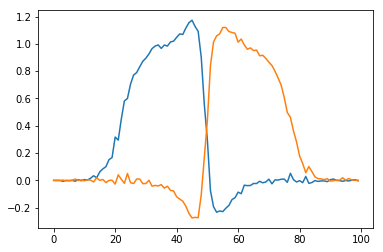

In [11]:
# Here is how we make the best of both world? No it's biased

def jrr(X, Y):
    ols = LinearRegression(fit_intercept=False)
    bagging = ShuffleSplit(2, test_size=.5)
    ensemble = [split for split in bagging.split(X, Y)]
    
    Hs = list()
    for train, test in ensemble:
        X_hat = ols.fit(Y[train], X[train]).predict(Y[test])
        Hs += [ols.fit(X[test], X_hat).coef_, ]

    # Estimate E
    E = np.mean(Hs, 0)
    return np.diag(E)  # TODO: check transpose

multi_jrr = list()
for t in range(n_times):
    multi_jrr.append(jrr(X, Y[:, :, t]))
plt.plot(multi_jrr)
# But a weird negative effect is still present; we need to account for this

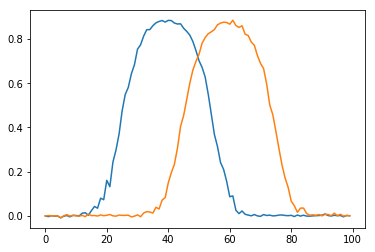

In [12]:
# Here is our final version

def jrr2(X, Y):
    """Unbiased JRR"""
    ridge = RidgeCV(np.logspace(-4, 4, 10), fit_intercept=False)
    ols = LinearRegression(fit_intercept=False)
    bagging = KFold(2)
    ensemble = [split for split in bagging.split(X, Y)]
    
    Hs = np.zeros((len(ensemble), len(X.T), len(X.T)))
    for split, (train, test) in enumerate(ensemble):
        for i in range(len(X.T)):
            not_i = [j for j in range(len(X.T)) if j != i]
            XY = np.concatenate((X[:, not_i], Y), axis=1)
            X_hat = ridge.fit(XY[train], X[train, i]).predict(XY[test])
            Hs[split, i] = ols.fit(X[test], X_hat).coef_

    # Estimate E
    return np.diag(np.mean(Hs, 0).T)  # TODO: check transpose

multi_jrr2 = list()
for t in range(n_times):
    multi_jrr2.append(jrr2(X, Y[:, :, t]))
plt.plot(multi_jrr2)

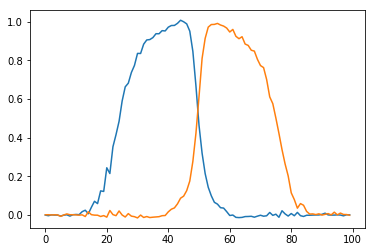

In [16]:
# Here is our final version

def jrr3(X, Y):
    """Unbiased JRR"""
    ridge = RidgeCV(np.logspace(-4, 4, 10), fit_intercept=False)
    ols = LinearRegression(fit_intercept=False)
    bagging = KFold(2)
    ensemble = [split for split in bagging.split(X, Y)]
    
    Hs = np.zeros((len(ensemble), len(X.T), len(X.T)))
    for split, (train, test) in enumerate(ensemble):
        for i in range(len(X.T)):
            not_i = [j for j in range(len(X.T)) if j != i]
            XY = np.concatenate((X[:, not_i], Y), axis=1)
            X_hat_xy = ridge.fit(XY[train], X[train, i]).predict(XY[test])
            X_hat_x = ridge.fit(X[train,][:,not_i], X[train, i]).predict(X[test][:,not_i])
            X_hat_y = ridge.fit(Y[train], X[train, i]).predict(Y[test])
            X_hat = (X_hat_xy + X_hat_y - X_hat_x) / 2.
            Hs[split, i] = ols.fit(X[test], X_hat).coef_

    # Estimate E
    return np.diag(np.mean(Hs, 0).T)  # TODO: check transpose

multi_jrr3 = list()
for t in range(n_times):
    multi_jrr3.append(jrr3(X, Y[:, :, t]))
plt.plot(multi_jrr3)

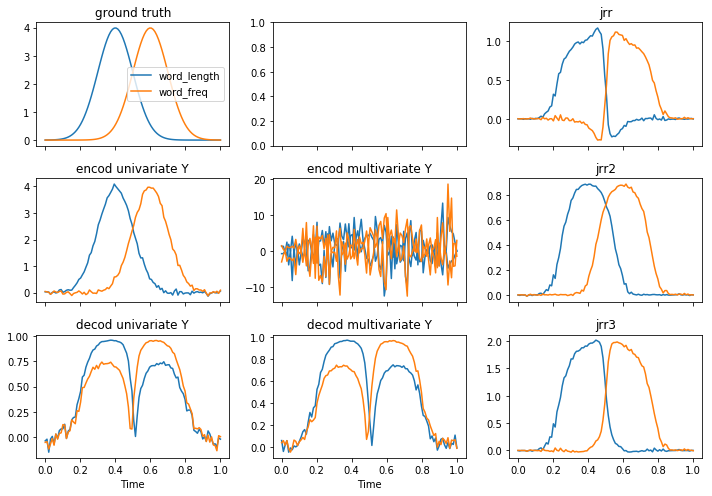

In [15]:
# all
fig, axes = plt.subplots(3, 3, figsize=[10, 7], sharex=True)
axes[0, 0].plot(time, word_length, label='word_length')
axes[0, 0].plot(time, word_freq, label='word_freq')
axes[0, 0].set_title('ground truth')
axes[0, 0].legend()

axes[1, 0].plot(time, encod)
axes[1, 0].set_title('encod univariate Y')

axes[2, 0].plot(time, decod)
axes[2, 0].set_title('decod univariate Y')

axes[0, 2].plot(time, multi_jrr)
axes[0, 2].set_title('jrr')

axes[1, 2].plot(time, multi_jrr2)
axes[1, 2].set_title('jrr2')

axes[2, 2].plot(time, multi_jrr3)
axes[2, 2].set_title('jrr3')


axes[1, 1].plot(time, multi_encod[0].T, color='C0')
axes[1, 1].plot(time, multi_encod[1].T, color='C1')
axes[1, 1].set_title('encod multivariate Y')

axes[2, 1].plot(time, multi_decod)
axes[2, 1].set_title('decod multivariate Y')

axes[2, 0].set_xlabel('Time')
axes[2, 1].set_xlabel('Time')
fig.tight_layout()